# OpenMS Python interface

This notebook is a collection of notes for working with OpenMS Python bindings (pyOpenMS). 

In [1]:
import pyopenms as oms
import os
import matplotlib.pyplot as plt

In [2]:
# Define the paths to the data files.
MZML_PATH = '/home/prichter/Documents/data/selenobot/ecoli/ms/mzml/'
ECOLI_PATH = '/home/prichter/Documents/data/selenobot/ecoli/'

`pyopenms` contains functions for loading an `mzML` file into an object (called an `MSExperiment`. I should note that, as of now, the files I am loading into this notebook have not been centroided (although it is not clear whether or not the MS2-level data has already been centroided). 

In [3]:
def load_mzml(filename:str) -> oms.MSExperiment:
    '''Function for loading an mzML file into an pyOpenMS object.'''
    mzml = oms.MSExperiment()
    oms.MzMLFile().load(os.path.join(MZML_PATH, filename), mzml)
    return mzml

In [4]:
mzml = load_mzml('A14-07017.mzML')

Now that the file has been loaded, I want to see what the different methods are. The documentation walkthrough is not always the most clear thing ever. 

In [5]:
print('Result of the size() method:', mzml.size())
print('Number of elements returned by getSpectra():', len(mzml.getSpectra()))

Result of the size() method: 55241
Number of elements returned by getSpectra(): 55241


In [6]:
print('Number of MS level 1 spectra:', len([s for s in mzml.getSpectra() if s.getMSLevel() == 1]))
print('Number of MS level 2 spectra:', len([s for s in mzml.getSpectra() if s.getMSLevel() == 2]))

Number of MS level 1 spectra: 5511
Number of MS level 2 spectra: 49730


Based on descriptions in the methodology section of the paper, I expected there to be 10 level 2 spectra for each level 1 spectrum: "...followed by 10 MS/MS scans of the most intense precursor ions in the Orbitrap acquired at a target setting of 50,000 ions, accumulation time of 100 ms and a resolution of 15,000 FWHM (at 400 m/z)."

In [7]:
print(49730/10)

4973.0


In [8]:
spectrum = mzml.getSpectra()[5]
# The spectra can also be indexed directly, like this.
# spectrum = mzml[0]

In [9]:
print('Result of getRT(), which is probably retention time:', spectrum.getRT())
print('Result of getMinIntensity():', spectrum.getMinIntensity())
print('Result of getMaxIntensity():', spectrum.getMaxIntensity())
print('Result of getMSLevel():', spectrum.getMSLevel())

Result of getRT(), which is probably retention time: 1.64419999998
Result of getMinIntensity(): 1.7976931348623157e+308
Result of getMaxIntensity(): -1.7976931348623157e+308
Result of getMSLevel(): 2


In [10]:
mz, i = spectrum.get_peaks()
# These should be equal, but don't seem to be? Oh just kidding they are. 
print('Number of mass-to-charge ratios:', len(mz), 'Number of intensities:', len(i))

Number of mass-to-charge ratios: 30 Number of intensities: 30


Based on the plots of the spectrum, it does seem as though the mass-spec data were collected in "profile mode" as opposed to "centroid mode." This means I definitely need to do centroiding on my own. *I am not entirely convinced that it is not in centroid mode already, because this might just be how the plotting displays it. Honestly not sure, but I don't think it's centroided based on other stuff I read, and the fact that the paper loads it into Progenitor, which also carries out centroiding on the spectra.*

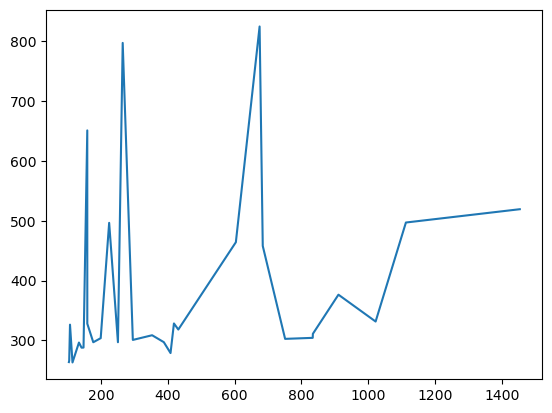

In [11]:
plt.plot(mz, i)

In [12]:
print('Peak intensities:', i)
print('Mass-to-charge ratio:', mz)

Peak intensities: [263.52286 266.13702 326.17728 262.8926  296.23068 287.67426 287.8162
 651.1999  327.79538 296.7337  303.5818  496.53403 296.77133 797.6097
 300.62595 308.4697  296.8809  278.6395  328.1857  318.00113 464.12216
 825.0965  457.87015 302.40045 304.11072 310.8477  376.3229  331.4121
 497.07816 519.3428 ]
Mass-to-charge ratio: [ 103.9103775   104.86095428  107.23867035  114.67763519  134.02745056
  141.81228638  147.72529602  158.96499634  159.03100586  176.90031433
  199.17089844  224.48348999  250.75660706  265.02487183  295.36703491
  353.11380005  388.15563965  408.2467041   418.45498657  431.52938843
  603.88146973  674.96600342  684.41577148  751.35687256  833.99926758
  834.48986816  911.04095459 1022.34191895 1113.06774902 1454.09924316]


I am starting to think that maybe all of the MS level 1 spectra are effectively empty (not totally sure why). *Ok so this is not true, it's just that some of them have a lot of peak intensities which are zero.*

I am also curious about how many peaks are present in each sample? And how do they calculate the peaks, without initial peak finding step? It does seem as though there are different numbers of peaks in each sample, but *how* they are being computed is still unclear. 

In [13]:
for s in mzml.getSpectra():
    if s.getMSLevel() == 1:
        _, i = s.get_peaks()
        # print('Number of peaks:', len(i))
        # print('Sum of the peak intensities:', sum(i))

## Did centroiding during mzML conversion work?

After reading a little more about preprocessing, I realized I need to carry out a process called centroiding on the data. According to [this](https://training.galaxyproject.org/training-material/topics/proteomics/tutorials/protein-id-oms/tutorial.html) tutorial, you can do this during the conversion of RAW files to mzML files using the `mscovert` tool. I tried this, and saved the centroided spectra as separate files. 

In [14]:
mzml = load_mzml('A14-07017.mzML')
mzml_ctr = load_mzml('A14-07017_ctr.mzML')

In [15]:
spectrum, spectrum_ctr = mzml[0], mzml_ctr[0]
mz, i = spectrum.get_peaks()
mz_ctr, i_ctr = spectrum_ctr.get_peaks()

In [16]:
# These should be the same. 
print('Centroided spectrum MS level:', spectrum_ctr.getMSLevel())
print('Non-centroided spectrum MS level:', spectrum.getMSLevel())

Centroided spectrum MS level: 1
Non-centroided spectrum MS level: 1


Unfortunately, it doesn't seem to have done anything (I'll also note that I centroided both MS levels, so that's not the issue, I don't think). 

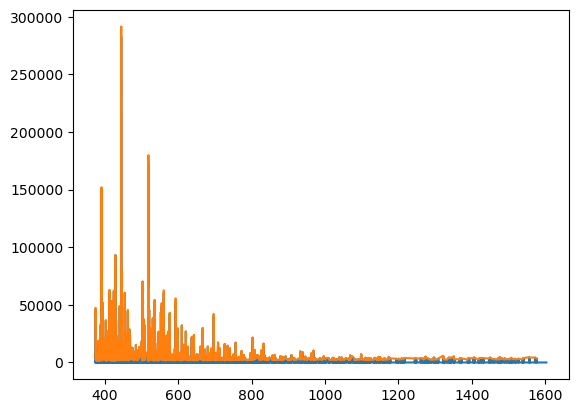

In [30]:
fig, ax = plt.subplots(1)
ax.plot(mz, i)
ax.plot(mz_ctr, i_ctr)
plt.show()

## Trying centroiding using `pyOpenMS`

`pyOpenMS` has built-in functions for centroiding (which, I am guessing, are just calling the functions I used earlier). Tutorial for doing this is [here](https://pyopenms.readthedocs.io/en/latest/user_guide/centroiding.html). 

In [18]:
# print(dir(oms.PeakPickerHiRes()))
?oms.PeakPickerHiRes.setParameters

In [19]:
params = oms.PeakPickerHiRes().getParameters().asDict()
for p, v in params.items():
    print(p.decode('utf-8'), v, f'type={type(v)}')

signal_to_noise 0.0 type=<class 'float'>
spacing_difference_gap 4.0 type=<class 'float'>
spacing_difference 1.5 type=<class 'float'>
missing 1 type=<class 'int'>
ms_levels [] type=<class 'list'>
report_FWHM false type=<class 'str'>
report_FWHM_unit relative type=<class 'str'>
SignalToNoise:max_intensity -1 type=<class 'int'>
SignalToNoise:auto_max_stdev_factor 3.0 type=<class 'float'>
SignalToNoise:auto_max_percentile 95 type=<class 'int'>
SignalToNoise:auto_mode 0 type=<class 'int'>
SignalToNoise:win_len 200.0 type=<class 'float'>
SignalToNoise:bin_count 30 type=<class 'int'>
SignalToNoise:min_required_elements 10 type=<class 'int'>
SignalToNoise:noise_for_empty_window 1e+20 type=<class 'float'>
SignalToNoise:write_log_messages true type=<class 'str'>


In [21]:
mzml_ctr = oms.MSExperiment()

# The PeakPickerHiRes seems to want to take the entire experiment at once, 
# so I'll just pass in the original thing loaded from the mzML. 

picker = oms.PeakPickerHiRes()
# picker = oms.PeakPickerIterative()
params = picker.getDefaults()
# params.setValue(b'signal_to_noise', 1.0)
# params.setValue(b'spacing_difference', 5.0)
params.setValue(b'mslevels', [1, 2])

# The "True" just means that an exception will be thrown if an already-centroided spectrum is passed. 
# How does it know that it's been centroided? Some kind of flag in the MSExperiment object, maybe?
# In which case it won't tell me anything about the RAW data.
picker.setParameters(params)
picker.pickExperiment(mzml, mzml_ctr, True)

In [25]:
spectrum, spectrum_ctr = mzml[0], mzml_ctr[0]
mz, i = spectrum.get_peaks()
mz_ctr, i_ctr = spectrum_ctr.get_peaks()

Ok so this also seems to have done nothing. Maybe this means it is already centroided?

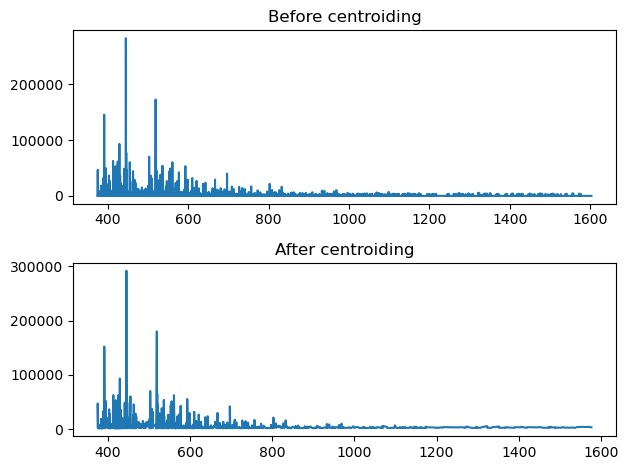

In [29]:
fig, axes = plt.subplots(2)
# ax.set_xlim(600, 650)
axes[0].plot(mz, i)
axes[0].set_title('Before centroiding')
axes[1].plot(mz_ctr, i_ctr)
axes[1].set_title('After centroiding')
plt.tight_layout()
plt.show()

## Do the MS2 spectra store estimated mass in metadata?

One of the things that is currently mistifying me about X! Tandem is how they are computing mass from MS2 spectra. I am wondering if the machine incldes the mass calculated from the MS1 spectrum when generating the MS2 files. 

In [5]:
ms2_spectrum = mzml[2]
print('MS level:', ms2_spectrum.getMSLevel())

MS level: 2


In [7]:
dir(ms2_spectrum)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_findNearest_0',
 '_findNearest_1',
 '_findNearest_2',
 '_init_0',
 '_init_1',
 '_set_peaks_fast_dd',
 '_set_peaks_fast_df',
 '_set_peaks_orig',
 'calculateTIC',
 'clear',
 'clearMetaInfo',
 'clearRanges',
 'containsIMData',
 'findHighestInWindow',
 'findNearest',
 'getAcquisitionInfo',
 'getComment',
 'getDataProcessing',
 'getDriftTime',
 'getDriftTimeUnit',
 'getDriftTimeUnitAsString',
 'getFloatDataArrays',
 'getIMData',
 'getInstrumentSettings',
 'getIntegerDataArrays',
 'getKeys',
 'getMSLevel',
 'getMaxIntensity',
 'getMaxMZ',
 'getMetaValue',
 'getMi

In [21]:
precursors = ms2_spectrum.getPrecursors()
precursor = precursors[0]

In [22]:
dir(precursor)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init_0',
 '_init_1',
 'addCVTerm',
 'clearMetaInfo',
 'consumeCVTerms',
 'empty',
 'getActivationEnergy',
 'getActivationMethods',
 'getCVTerms',
 'getCharge',
 'getDriftTime',
 'getDriftTimeWindowLowerOffset',
 'getDriftTimeWindowUpperOffset',
 'getIntensity',
 'getIsolationWindowLowerOffset',
 'getIsolationWindowUpperOffset',
 'getKeys',
 'getMZ',
 'getMetaValue',
 'getPos',
 'getPossibleChargeStates',
 'getUnchargedMass',
 'hasCVTerm',
 'isMetaEmpty',
 'metaRegistry',
 'metaValueExists',
 'removeMetaValue',
 'replaceCVTerm',
 'replaceCVTerms',
 'setActivationEnergy',
 'setActivationMethods',
 'setCVTerms',
 'setCh

In [26]:
print('Output of getCharge() method:', precursor.getCharge())
if not precursor.isMetaEmpty():
    print('Output of getMetaValue() method:', precursor.isMetaEmpty())
print('output of getMZ() method:', precursor.getMZ())

Output of getCharge() method: 2
Output of getMetaValue() method: False
output of getMZ() method: 879.048034667969
